In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support

from scipy.stats import ttest_ind

%matplotlib inline


In [2]:
# Pull in the dataset
df_raw = pd.read_csv('..//Datasets//creditcard.csv')

# Show the shape and the head
print(df_raw.shape)
df_raw.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [70]:
# From the first few rows, it appears that the data is already normalized. Let's check.
df_raw.groupby(df_raw.columns, axis=1).describe().head(n=7)

,,count,mean,std,min,25%,50%,75%,max
Amount,Amount,284807.0,8.834962e+01,250.120109,0.000000,5.600000,22.000000,77.165000,25691.160000
Class,Class,284807.0,1.727486e-03,0.041527,0.000000,0.000000,0.000000,0.000000,1.000000
Time,Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V10,V10,284807.0,1.768627e-15,1.088850,-24.588262,-0.535426,-0.092917,0.453923,23.745136
V11,V11,284807.0,9.170318e-16,1.020713,-4.797473,-0.762494,-0.032757,0.739593,12.018913
V12,V12,284807.0,-1.810658e-15,0.999201,-18.683715,-0.405571,0.140033,0.618238,7.848392


It appears that all of the PCA Columns average out to zero, and have small standard deviations. Since the Amount and Time data are much larger than the other columns, we will have to scale them as well. Even when the "V" columns have a large range, their IQR is still approximately -1 <-> 1, which means that there are outliers present. I will preserve the outliers from the Amount and Time columns with sklearn's standard scaler method. The Normalize method would shrink everything to be explicitly between -1 and 1, and we don't want that.

In [73]:
print('Check for missing values: \nThere are {0:} missing values'.format(df_raw.isnull().sum().max()))

# Split our training data
X_train, X_test, y_train, y_test = train_test_split(df_raw.drop('Class', 1).copy(),
                                                    df_raw.loc[:, 'Class'].copy(),
                                                    random_state=42)

# Create scaler object using the X_train variable
scaler = StandardScaler().fit(X_train.loc[:, ('Amount', 'Time')])

# Standardize X_train and X_test values
standardized_X = scaler.transform(X_train.loc[:, ('Amount', 'Time')])
standardized_X_test = scaler.transform(X_test.loc[:, ('Amount', 'Time')])

# Change the X_train and X_test to our new standardized values
X_train.loc[:, ('Amount', 'Time')], X_test.loc[:, ('Amount', 'Time')] = standardized_X, standardized_X_test
X_train.head()

Check for missing values: 
There are 0 missing values


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
83225,-0.738270,-1.648591,1.228130,1.370169,-1.735542,-0.029455,-0.484129,0.918645,-0.438750,0.982144,...,0.384201,-0.218076,-0.203458,-0.213015,0.011372,-0.304481,0.632063,-0.262968,-0.099863,-0.196016
52800,-1.035079,-0.234775,-0.493269,1.236728,-2.338793,-1.176733,0.885733,-1.960981,-2.363412,-2.694774,...,0.364679,-1.495358,-0.083066,0.074612,-0.347329,0.541900,-0.433294,0.089293,0.212029,-0.107223
21293,-1.331382,1.134626,-0.774460,-0.163390,-0.533358,-0.604555,-0.244482,-0.212682,0.040782,-1.136627,...,-0.396476,-0.684454,-1.855269,0.171997,-0.387783,-0.062985,0.245118,-0.061178,0.012180,0.086696
133600,-0.302019,0.069514,1.017753,1.033117,1.384376,0.223233,-0.310845,0.597287,-0.127658,-0.701533,...,0.148760,0.097023,0.369957,-0.219266,-0.124941,-0.049749,-0.112946,0.114440,0.066101,-0.306794
38225,-1.168730,-0.199441,0.610092,-0.114437,0.256565,2.290752,4.008475,-0.123530,1.038374,-0.075846,...,0.292972,-0.019733,0.165463,-0.080978,1.020656,-0.300730,-0.269595,0.481769,0.254114,-0.260020


That's kind of nice, our data has already been cleaned of missing values. Is that a result of PCA? Not necessarily in this case, because whoever made the data may have imputed, but I was wondering if PCA would fill a missing value since the data is being transformed onto a different vector space. So many questions.

In [83]:
# First, let's try an SVC with l2 regularization
clf = LinearSVC(class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
target_names = ['Non-Fraudulent', 'Fraudulent']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.73      0.77      0.75       113

   avg / total       1.00      1.00      1.00     71202



An important thing to note in this application is that banks want to be absolutely sure that they do not let fraudsters go unnoticed. They will get fined by the government out the wazoo, so they would rather report a ton of false positives because then they can be sure that they don't get fined. It mostly serves to help narrow down the search for fraudsters, and not necessarily call each of them out individually. I learned this from my mentor.

What this means for us, is that we need to have a very high recall. A recall of 1 is ideal, so let's try to force that so our branch doesn't get fined.

For my memory/understanding, 'recall' corresponds to doctor's being 'really' careful to not miss cancer patients. An example of high 'precision' is a very 'precise' advertising campaign. You don't want to send ads to people that won't look at them (kinda like a false positive), so you only send ads to people that you think are more likely to respond to them. In this way you get most bang for your advertising buck.

In [85]:
# And let's try an SVC with L1 regularization. I doubt this will be any better, because PCA has reduced data
# to only the important eigan features, so zeroing out feature coefficients wouldn't help that much. 
clf = LinearSVC(class_weight='balanced', loss='hinge')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
target_names = ['Non-Fraudulent', 'Fraudulent']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

Non-Fraudulent       1.00      1.00      1.00     71089
    Fraudulent       0.75      0.81      0.78       113

   avg / total       1.00      1.00      1.00     71202



Not the first time I've been wrong, and it won't be the last! There is a way to increase our recall in the initialization of our Linear SVC, so let's learn/do that real quick and see if it gets us to 100% recall. To converge on a class weight more quickly, I will use a subset of the data. I will show that the class imbalance is similar.

Ttest_indResult(statistic=0.05962281678410607, pvalue=0.9524561013045016) 

Original Imbalance: 
0.178%

Subset Imbalance: 
0.165%



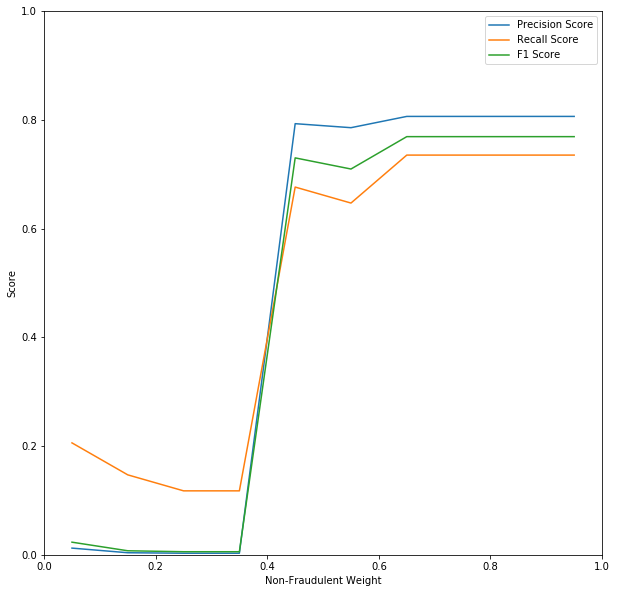

In [179]:
resolution = 1 # How small of increments will we need? I don't know. Let's use 100 for now, by 5
n_steps = 10
start = .05
stop = 1
n_subset_examples = 20000

# Let's use the subset and ensure our class imbalance is roughly the same using a t-test
print(ttest_ind(y_train, y_train.iloc[0:2]), '\n')
print('Original Imbalance: \n{:.3f}%\n'.format(100 * y_train.value_counts()[1] / y_train.value_counts()[0]))
print('Subset Imbalance: \n{:.3f}%\n'.format(100 * y_train.iloc[0:n_subset_examples].value_counts()[1] / 
                                           y_train.iloc[0:n_subset_examples].value_counts()[0]))

precision_scores = []
recall_scores = []
f1_scores = []
thresholds = []

for i in np.arange(start, stop, resolution/n_steps):
    # Initialize the LinearSVC with different class weights
    clf = LinearSVC(class_weight={0:i, 1:100-i}, loss='hinge')
    clf.fit(X_train.iloc[:n_subset_examples], y_train.iloc[:n_subset_examples])
    y_pred = clf.predict(X_test.iloc[:n_subset_examples])
    target_names = ['Non-Fraudulent', 'Fraudulent']
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test.iloc[:n_subset_examples], y_pred, average='binary')
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1_score)
    thresholds.append(i)

plt.figure(figsize=(10, 10))

# Plot all three scores on the same graph
plt.plot(thresholds, precision_scores, label='Precision Score')
plt.plot(thresholds, recall_scores, label='Recall Score')
plt.plot(thresholds, f1_scores, label='F1 Score')

# Make it look nice
plt.xlabel('Non-Fraudulent Weight')
plt.ylabel('Score')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()

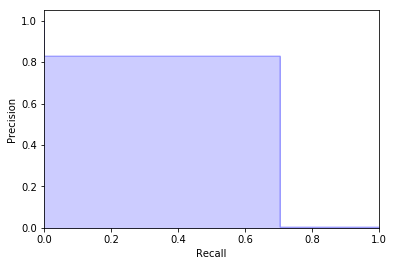

In [174]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test.iloc[:n_subset_examples], y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))
plt.show()

In [150]:
# classification_report(y_test, y_pred, target_names=target_names) #[0:30]
print('{:.5f}'.format(y_train.value_counts()[1] / y_train.value_counts()[0]))
print('{:.5f}'.format(y_train.iloc[0:n_subset_examples].value_counts()[1] / 
                      y_train.iloc[0:n_subset_examples].value_counts()[0]))

0.0018
0.0019
